In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

(641, 1)
320.0
(641, 1)
(1281, 1)


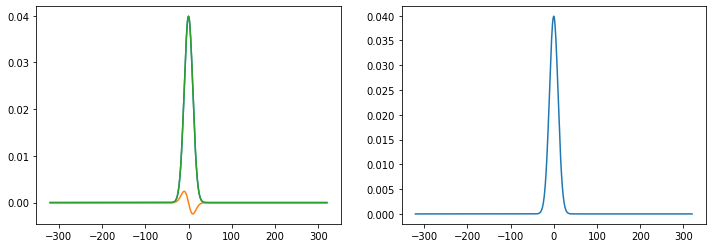

In [280]:
# Exercise 6.1
def gaussian1DKernel(sigma,rule=5,eps=0):
    if eps:
        filter_size=eps
    else:
        filter_size = np.ceil(rule*np.ceil(sigma))
    x_row = np.arange(-filter_size,filter_size+1)
    #g_1 = g_1[:,np.newaxis]
    g = 1/(np.sqrt(2*np.pi*sigma**2))* np.exp((-x_row**2)/(2*sigma**2))
    #gx = -(-x_row**2/(2*sigma**2)) * g
    gx = - x_row / sigma ** 2 * g
    g = g[:,np.newaxis]
    gx = gx[:,np.newaxis]
    return g, gx, x_row
    
    
    
g, gx,x = gaussian1DKernel(10,rule=2**5)
g1,gx1,x2 = gaussian1DKernel(10,rule=2**6)
print(g.shape)
print(np.floor(g.shape[0]/2))
#print(x2[int(np.floor(g.shape[0]/2)):int(-np.floor(g.shape[0]/2))])
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x,g)
ax.plot(x,gx)
ax.plot(x2[int(np.floor(g.shape[0]/2)):int(-np.floor(g.shape[0]/2))],g1[int(np.floor(g.shape[0]/2)):int(-np.floor(g.shape[0]/2))])
ax = fig.add_subplot(1,2,2)
ax.plot(x2[int(np.floor(g.shape[0]/2)):int(-np.floor(g.shape[0]/2))],g1[int(np.floor(g.shape[0]/2)):int(-np.floor(g.shape[0]/2))])
print(g.shape)
print(g1.shape)


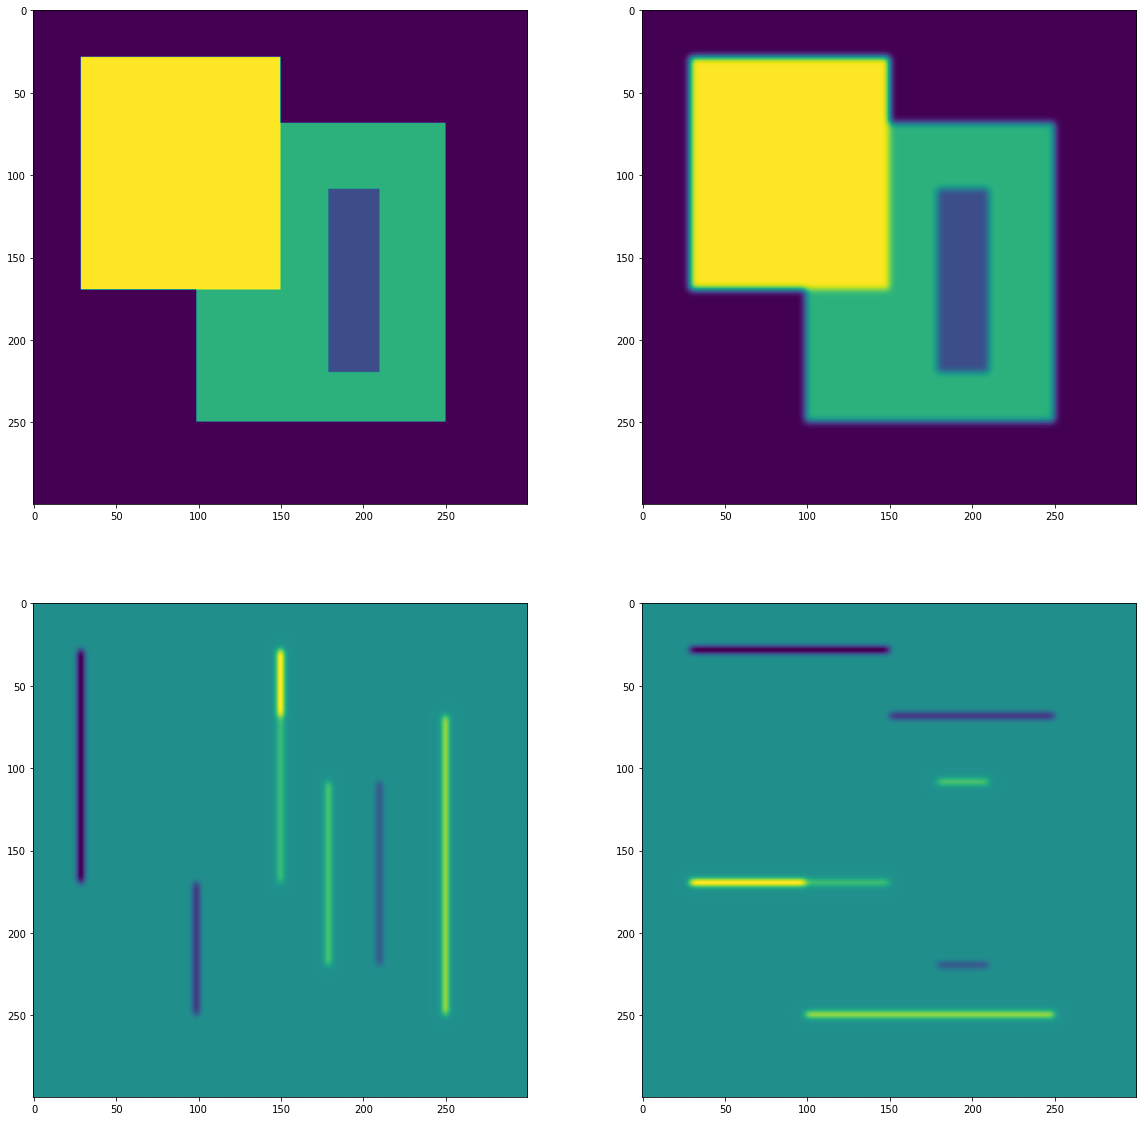

In [219]:
# Exercise 6.2
def gaussianSmoothing(im,sigma,rule=5):
    g,gx,_ = gaussian1DKernel(sigma,rule=rule)
    I = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, g) 
    Ix = (cv2.filter2D(cv2.filter2D(im, -1, gx.T), -1, g))
    Iy = (cv2.filter2D(cv2.filter2D(im, -1, gx), -1, g.T))
    
    #I = (g@g.T)@im
    #Ix = (g@gx.T)@im
    #Iy = (gx@g.T)@im
    
    return I, Ix, Iy

img = cv2.imread('week06_data/TestIm1.png')
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32)
I,Ix,Iy = gaussianSmoothing(img,2,rule=5)
fig = plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(img)
fig.add_subplot(2,2,2)
plt.imshow(I)
fig.add_subplot(2,2,3)
plt.imshow(Ix)
fig.add_subplot(2,2,4)
plt.imshow(Iy)
plt.show()



(2, 2, 300, 300)


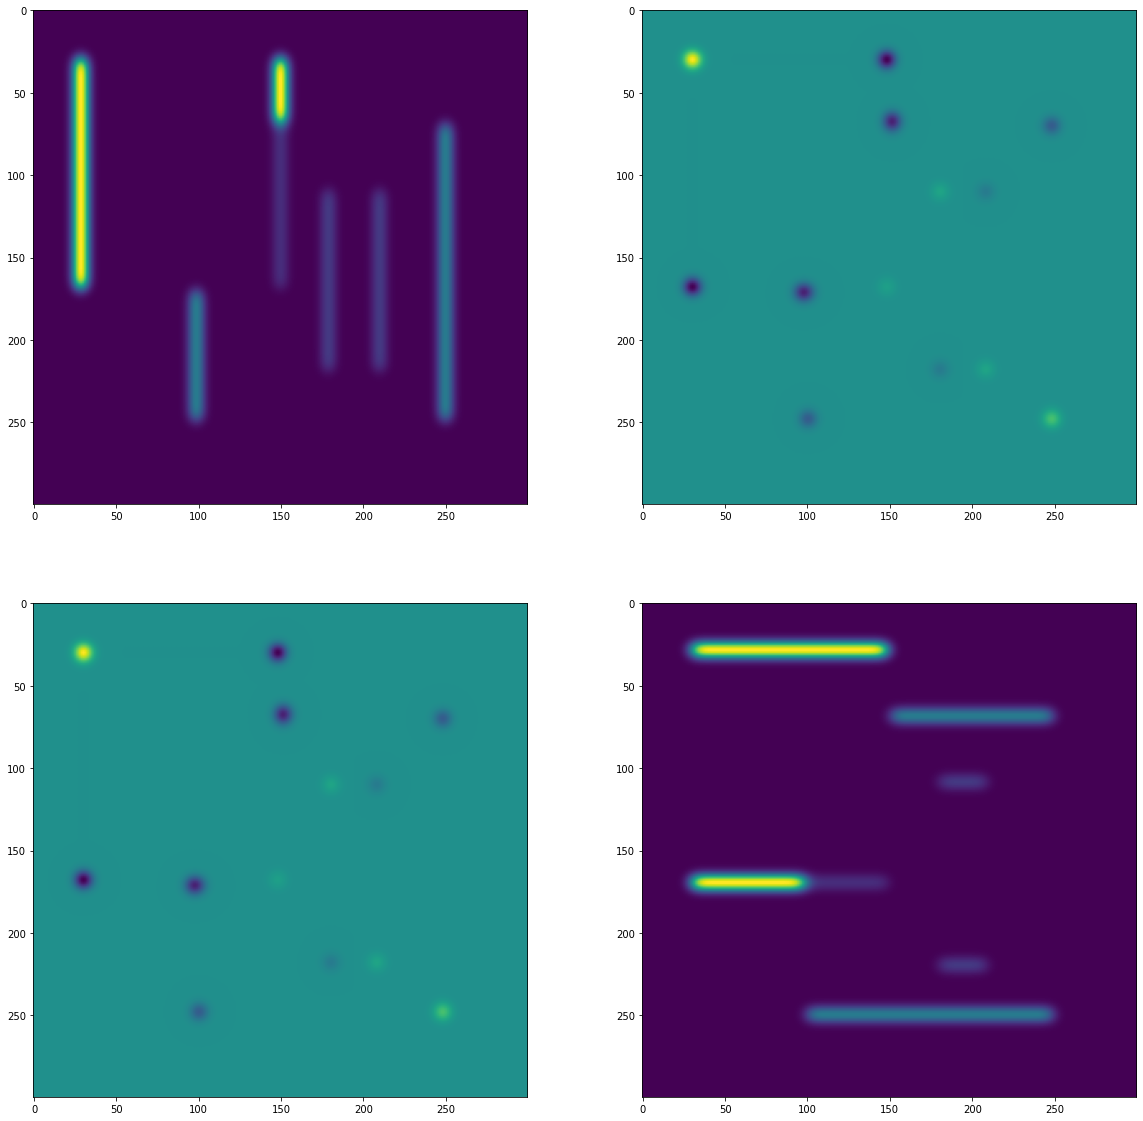

In [220]:
# Exercise 6.3

def smoothedHessian(im, sigma, epsilon,rule=5):
    I, Ix, Iy = gaussianSmoothing(im,sigma,rule=rule)
    g_eps, gx,_ = gaussian1DKernel(epsilon)
    a = cv2.filter2D(cv2.filter2D(Ix**2,-1,g_eps),-1,g_eps.T)
    b = cv2.filter2D(cv2.filter2D(Iy**2,-1,g_eps),-1,g_eps.T)
    c = cv2.filter2D(cv2.filter2D(Ix*Iy,-1,g_eps),-1,g_eps.T)
    #a = cv2.filter2D(Ix**2,-1,g_eps)
    #b = cv2.filter2D(Iy**2,-1,g_eps)
    #c = cv2.filter2D(Ix*Iy,-1,g_eps)
    C = np.array([[a,c],
                  [c,b]])
    return C


C = smoothedHessian(img,3,3)
                  

print(C.shape)


fig = plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(C[0,0])
fig.add_subplot(2,2,2)
plt.imshow(C[1,0])
fig.add_subplot(2,2,3)
plt.imshow(C[0,1])
fig.add_subplot(2,2,4)
plt.imshow(C[1,1])




(300, 300)
3576790.0


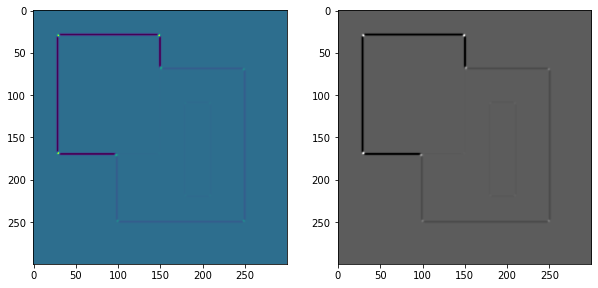

In [261]:
# Exercise 6.4

def harrisMeasure(im,sigma,epsilon,k):
    C = smoothedHessian(im,sigma,epsilon)
    a, b, c = C[0, 0, :, :], C[1, 1, :, :], C[1, 0, :, :]
    r = (a*b) - (c**2) - (k * ((a + b)**2))
    return r


sigma=1
epsilon = 1
k = 0.06
r = harrisMeasure(img, sigma=sigma, epsilon=epsilon, k=k)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(r)
fig.add_subplot(1,2,2)
plt.imshow(r,cmap='gray')
print(r.shape)
print(np.max(r))

(298, 298)
[[ 29  29]
 [ 29 149]
 [ 30  30]
 [ 30 148]
 [ 68 151]
 [ 69 249]
 [ 70 248]
 [109 179]
 [109 209]
 [110 180]
 [110 208]
 [168  30]
 [168 148]
 [169  29]
 [169 149]
 [171  98]
 [218 180]
 [218 208]
 [219 179]
 [219 209]
 [248 100]
 [248 248]
 [249  99]
 [249 249]]


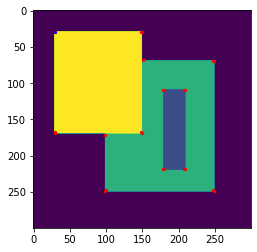

In [262]:
# Exercise 6.5
def cornerDetector(im,sigma,epsilon,k,tau):
    r = harrisMeasure(im,sigma,epsilon,k)
    print(r[1:-1,2:].shape)
    local_max = np.zeros(im.shape, dtype=bool)
    local_max[1:-1, 1:-1] = (
          (r[1:-1, 1:-1] > r[1:-1, 2:  ]) 
        & (r[1:-1, 1:-1] > r[1:-1,  :-2])
        & (r[1:-1, 1:-1] > r[2:  , 1:-1])
        & (r[1:-1, 1:-1] > r[ :-2, 1:-1])
    )
    r[~local_max] = 0
    return np.argwhere(r > tau),r

c,r = cornerDetector(img, sigma, epsilon, k, tau=4000)
print(c)
fig = plt.figure()
ax = fig.add_subplot()
plt.imshow(img)
ax.scatter(c[:,1],c[:,0],s=5,c='r')
ax.scatter(29,29,s=4,c='b')

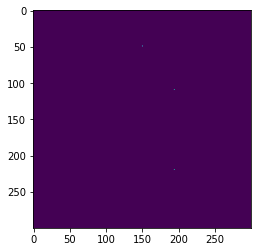

In [227]:
plt.imshow(r)

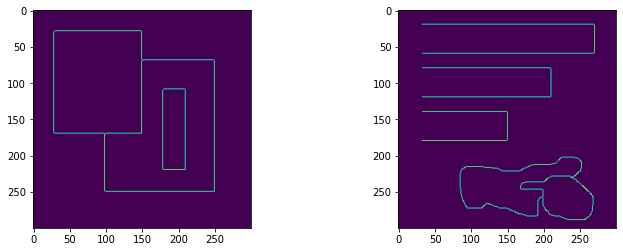

In [61]:
# Exercise 6.6

img2 = cv2.imread('week06_data/TestIm2.png')
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img,1,100)
edges2 = cv2.Canny(img2,25,500)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].imshow(edges)

plt.imshow(edges2)



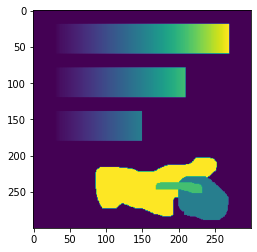

In [9]:
plt.imshow(img2)

here
here
done


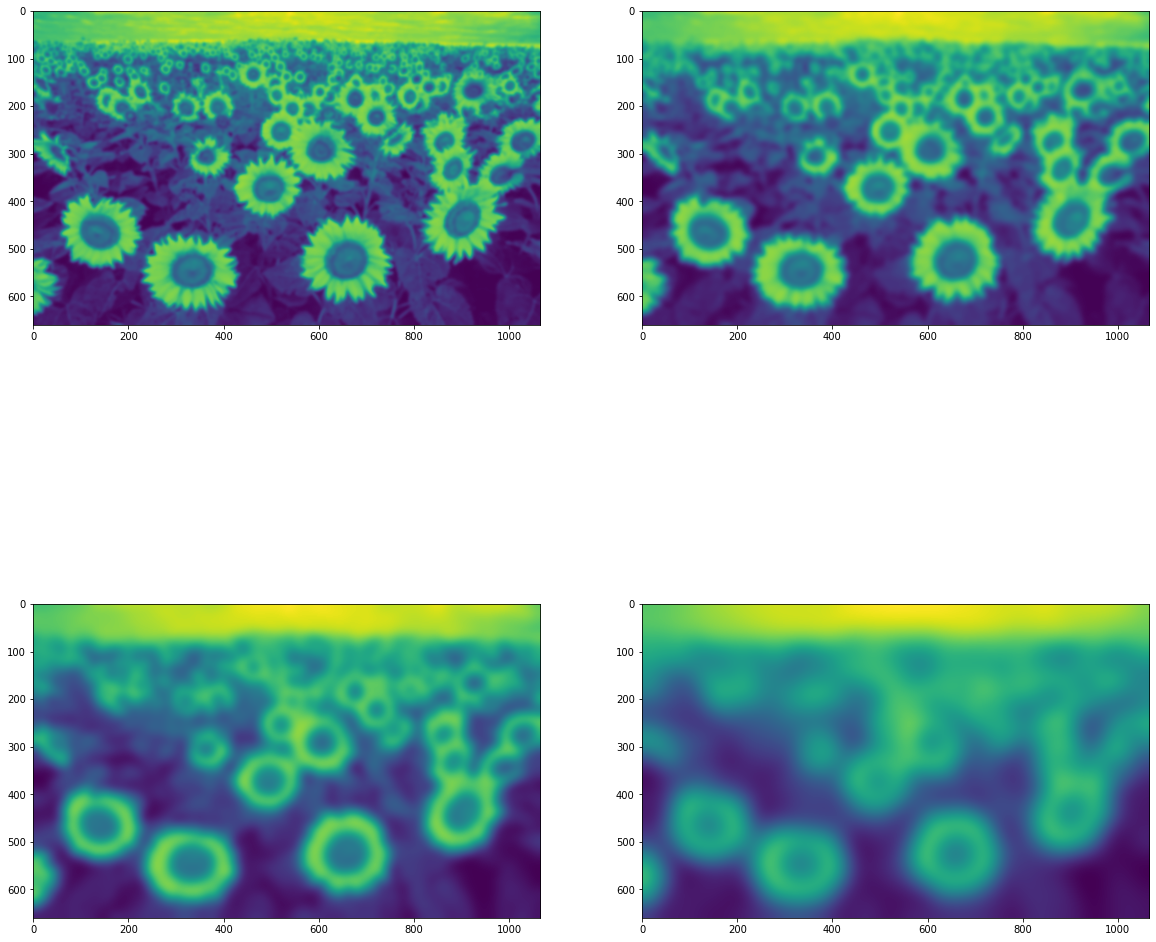

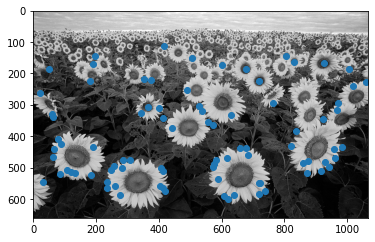